# Assignment 2 - Classification

_Tiffany Wang - 260684152_ 

### 3.1 Coding Questions

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2 
import os
import math
from PIL import Image

In [3]:
def HoG_features(images, cell_size=(4, 4), block_size=(4, 4), nbins=8):
    '''
    Creates a list of HoG features for each image. 
    :param images: list of images to be processed
    :param cell_size: shape of pixels window per cell 
    :param block_size: shape of cells window per block 
    :return: list of HoG features 
    '''
    features = []
    for img in images:
        h, w, _ = img.shape
        c_h, c_w = cell_size
        b_h, b_w = block_size
        
        # create HoG Object
        hog = cv2.HOGDescriptor(_winSize=(w // c_w * c_w, h // c_h * c_h),
                                _blockSize=(b_w * b_w, b_h * b_h),
                                _blockStride=(c_w, c_h),
                                _cellSize=(c_w, c_h),
                                _nbins=nbins)

        n_cells = (h // c_h, w // c_w)

        # Compute HoG features
        hog_feats = hog.compute(img) \
                       .reshape(n_cells[1] - b_w + 1, n_cells[0] - b_h + 1, b_h, b_w, nbins) \
                       .transpose((1, 0, 2, 3, 4))  
        
        # computation for BlockNorm
        gradients = np.zeros((n_cells[0], n_cells[1], nbins)).astype(np.float)
        cell_count = np.zeros((n_cells[0], n_cells[1], 1)).astype(np.float)

        for off_y in range(b_h):
            for off_x in range(b_w):
                gradients[off_y:n_cells[0] - b_h + off_y + 1, 
                          off_x:n_cells[1] - b_w + off_x + 1] += hog_feats[:, :, off_y, off_x, :]
                cell_count[off_y:n_cells[0] - b_h + off_y + 1,
                           off_x:n_cells[1] - b_w + off_x + 1] += 1

        # Average gradients
        gradients /= cell_count

        features.append(gradients)
    return features

In [4]:
max_col = 4
def plot_hog(features):
    '''
    Plot the features of every bin. 
    :param features: HoG Feature matrix
    :return: None
    '''
    nbins = features.shape[-1]
    nb_row = math.ceil(nbins / max_col)
    nb_plot = nb_row * 100 + max_col * 10
    plt.figure(figsize = (20,10))
    for i in range(features.shape[-1]):
        plt.subplot(nb_plot + i + 1)
        plt.pcolor(features[:, :, i])
        plt.gca().invert_yaxis()
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title("HOG bin = {}".format(i)), plt.xticks([]), plt.yticks([])
        plt.colorbar()
    plt.show()

###### 1. Resize the training images to 128 x 128.

In [5]:
# Load images and store them in training and test sets 
data = os.listdir('./dataset/')
ford_train = []
ford_test = []
vw_train = []
vw_test = []
size = (128, 128)

# Resize and store training and test images 
for file in data: 
    img = Image.open('./dataset/' + file)
    
    if (len(img.size) == 2): 
        img = img.convert('RGB')        
    img = img.resize(size)
    img = np.array(img)
    if file.startswith('ford_train'): 
        ford_train.append(img)
    elif file.startswith('ford_test'):
        ford_test.append(img)
    elif file.startswith('volks_train'): 
        vw_train.append(img)
    elif file.startswith('volks_test'): 
        vw_test.append(img)  
        
print('{} Ford training images'.format(len(ford_train)))
print('{} Ford training images'.format(len(ford_test)))
print('{} Volkswagen training images'.format(len(vw_train)))
print('{} Volkswagen training images'.format(len(vw_test)))

5 Ford training images
1 Ford training images
5 Volkswagen training images
1 Volkswagen training images


###### 2. Compute HoG features of size (32,32,8). Apply blocknorm in 4 x 4 cell neighborhood.

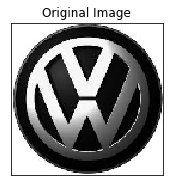

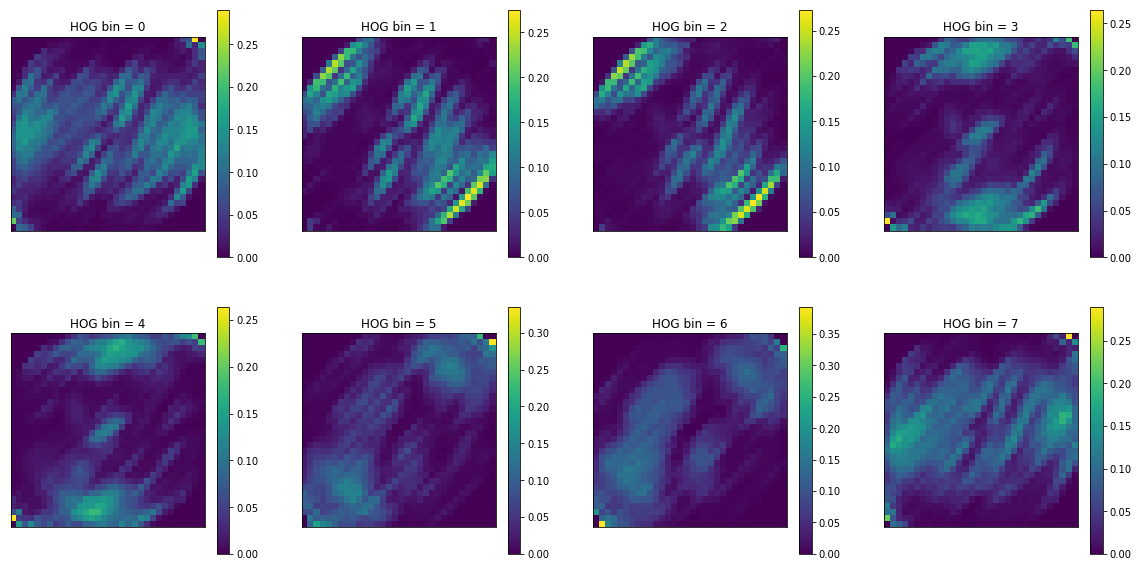

In [6]:
# img.shape = (128, 128, 3), so cell_size = (128 // 4, 128 // 4)
ford_features = HoG_features(ford_train)
vw_features = HoG_features(vw_train)

# test the feature extraction for one image 
img = vw_train[3]
gradients = vw_features[3]

# Preview
plt.figure(figsize = (6,6))
plt.subplot(121)
plt.imshow(img)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.show()

plot_hog(gradients)

In [7]:
from sklearn.neighbors import KNeighborsClassifier

# set up classifier
train_x = np.array(ford_features + vw_features)
train_x = train_x.reshape(train_x.shape[0], -1)
nb_ford_train = len(ford_train)
nb_vw_train = len(vw_train)

# create labels for training set
train_y = ['ford' for _ in range(nb_ford_train)] + ['volkswagen' for _ in range(nb_vw_train)]

# Instantiate classifier and train. 
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_x, train_y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

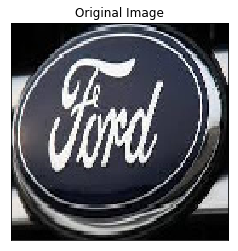

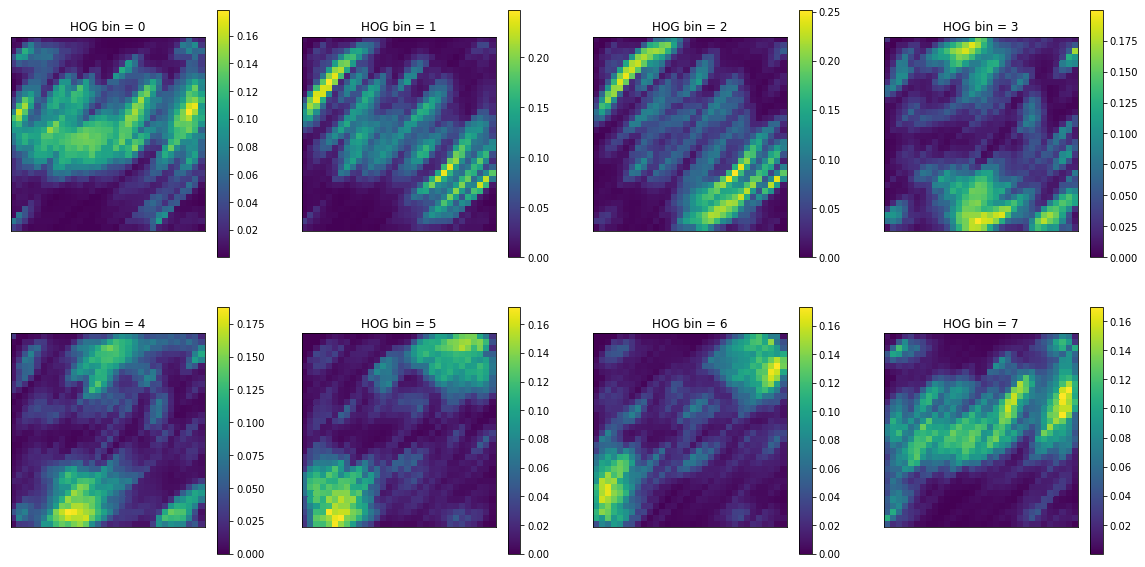

The image above was classified as ford


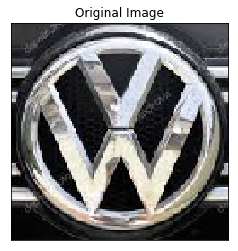

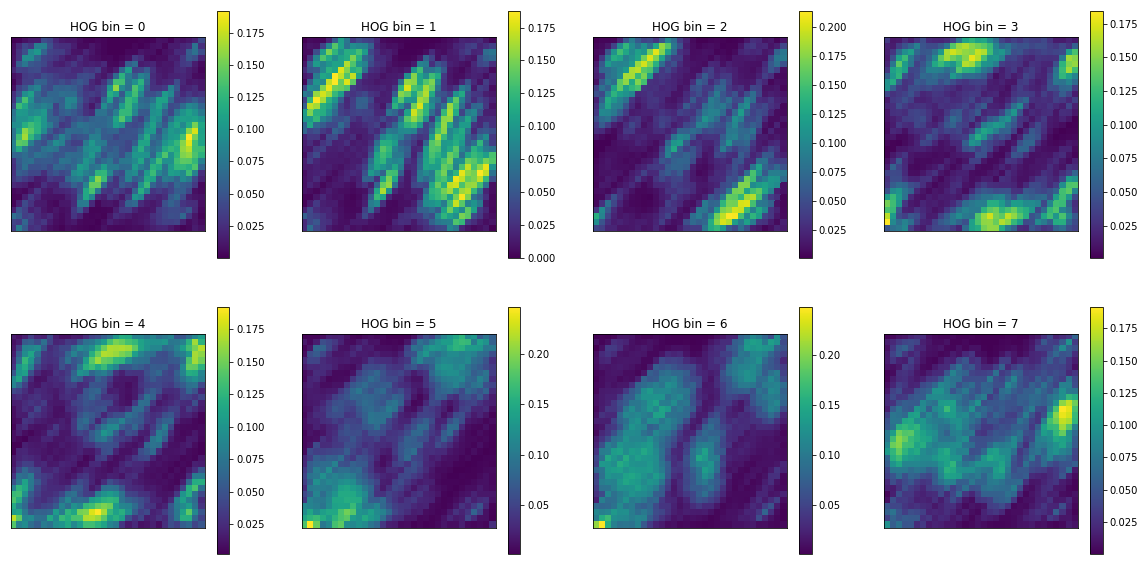

The image above was classified as volkswagen


In [8]:
##################
# PREDICT IMAGES #
##################
test_img = ford_test + vw_test
test_features = np.array(HoG_features(test_img))
test_y = neigh.predict(test_features.reshape(len(test_img), -1))
max_col = 4
for x, x_ft, y in zip(test_img, test_features, test_y):
    # Preview
    plt.figure(figsize = (6,4))
    plt.imshow(x)
    plt.title("Original Image"), plt.xticks([]), plt.yticks([])
    plt.show()
    
    plot_hog(x_ft)
    print('The image above was classified as', y)

### 3.2 Reasoning Questions

###### 1. Will HoG work if images of logos undergo random rotation? If yes, which property of HoG avails this feature? If not, discuss the sequence of computer vision technique(s) that can be used in order to regain uniform orientation of the logos.

HoG defines features by their orientation and scale, thus depends on the orientation of the image. Therefore, it won't work if the images are randomly rotated. Following the techniques in Part II of this assignment, we could find the feature descriptors, and matching points, to warp the images to the same orientation.  

###### 2. Consider that you are given a large dataset with three types of images: variable sized squares with either or both diagonals drawn (see Figure 3). How many and which directions of the gradient are $\textit{sufficient}$ in order to correctly classify the images into three categories?

Since there are only two possible directions, only two directions of the gradients when training the classifier. HoG would find the gradients normal to each diagonal, which will be used to classify the images. 